# RSTDP domain adaptation of pre-trained agents for modified CartPole environments

In [1]:
import os
from datetime import date

import numpy as np
import torch
import torch.optim as optim
import random
import gym
import matplotlib.pyplot as plt
from copy import deepcopy

from cartpole_stuff.src.utils import evaluate_policy, rstdp_train_cartpole

import site
site.addsitedir('../src/')

from cartpole_stuff.src.dsnn import RSTDPNet

%matplotlib inline

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dtype = torch.float

In [3]:
# Environment specific parameters
env_name = 'CartPole-v0'
max_reward = 200
max_steps = 200

n_evaluations = 100
rstdp_episodes = 250

In [4]:
# Create environments
original_env = gym.make(env_name)

modified_env = gym.make(env_name)
modified_env.unwrapped.length *= 1.5

/home/luuk/Desktop/testing/.venv/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [5]:
# SNN Hyperparameters
simulation_time = 8
alpha = 0.8
beta = 0.8
threshold = 0.5
weight_scale = 1
architecture = [4, 64, 64, 2]

In [6]:
# RSTDP Hyperparameters
tau = 5
tau_e = 10
C = 0.01
# A+/- are calculated from the pre-trained network weights

In [7]:
evaluation_seeds = np.load('cartpole_stuff/seeds/evaluation_seeds.npy')
rstdp_seeds = np.load('cartpole_stuff/seeds/rstdp_training_seeds.npy')

In [8]:
# Load pre-trained model weights
weights_0 = torch.load('cartpole_stuff/pretrained_models/cartpole/checkpoint_DSQN_0.pt', map_location=torch.device(device))
weights_1 = torch.load('cartpole_stuff/pretrained_models/cartpole/checkpoint_DSQN_1.pt', map_location=torch.device(device))
weights_2 = torch.load('cartpole_stuff/pretrained_models/cartpole/checkpoint_DSQN_2.pt', map_location=torch.device(device))
weights = [weights_0, weights_1, weights_2]
print(weights_0[0][0].size())

torch.Size([8, 64])


In [9]:
# Helper for printing
eraser = '\b \b'

### Evaluate pre-trained models on original environment

In [10]:
original_eval_rewards = []

for i, w in enumerate(weights):
    print('Run {:02d} ...'.format(i), end='')
    policy_net = RSTDPNet(alpha, beta, threshold, architecture, simulation_time, w, 
                                  device=device, dtype=dtype)
    rewards = evaluate_policy(policy_net, original_env, n_evaluations, evaluation_seeds)
    original_eval_rewards.append(rewards)
    print(eraser*3 + '-> Avg reward: {:7.2f}'.format(np.mean(rewards)))

Run 00 -> Avg reward:  199.73
Run 01 -> Avg reward:  200.00
Run 02 -> Avg reward:  200.00


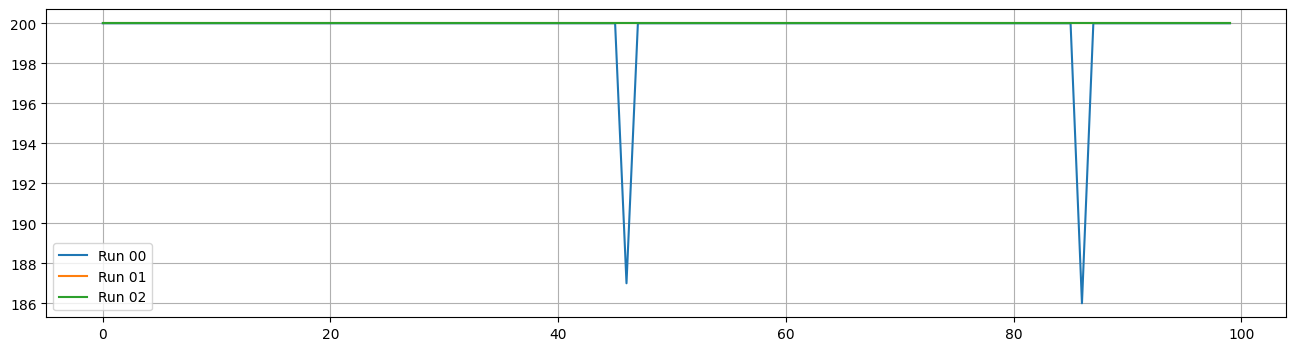

In [27]:
plt.figure(figsize=(16, 4))

for i, oer in enumerate(original_eval_rewards):
    plt.plot(oer, label='Run {:02d}'.format(i))

plt.legend()
plt.grid()
plt.show()

In [11]:
percentages = np.linspace(1.1, 2.0, 10)
all_modified_env_eval_rewards = []
for percentage in percentages:

    modified_env = gym.make(env_name)
    modified_env.unwrapped.length *= percentage

    modified_env_eval_rewards = []

    for i, w in enumerate(weights):
        print('Run {:02d} ...'.format(i), end='')
        policy_net = RSTDPNet(alpha, beta, threshold, architecture, simulation_time, w,
                                    device=device, dtype=dtype)
        rewards = evaluate_policy(policy_net, modified_env, n_evaluations, evaluation_seeds)
        modified_env_eval_rewards.append(rewards)
        print(eraser*3 + '-> Avg reward: {:7.2f}'.format(np.mean(rewards)))

    all_modified_env_eval_rewards.append(modified_env_eval_rewards)

Run 00 -> Avg reward:  199.47
Run 01 -> Avg reward:  200.00
Run 02 -> Avg reward:  200.00
Run 00 -> Avg reward:  199.60
Run 01 -> Avg reward:  200.00
Run 02 -> Avg reward:  200.00
Run 00 -> Avg reward:  199.35
Run 01 -> Avg reward:  200.00
Run 02 -> Avg reward:  200.00
Run 00 -> Avg reward:  195.59
Run 01 -> Avg reward:  200.00
Run 02 -> Avg reward:  197.20
Run 00 -> Avg reward:  186.41
Run 01 -> Avg reward:  200.00
Run 02 -> Avg reward:  132.76
Run 00 -> Avg reward:  158.48
Run 01 -> Avg reward:  200.00
Run 02 -> Avg reward:   53.62
Run 00 -> Avg reward:  154.69
Run 01 -> Avg reward:  200.00
Run 02 -> Avg reward:   44.52
Run 00 -> Avg reward:  129.41
Run 01 -> Avg reward:  200.00
Run 02 -> Avg reward:   43.07
Run 00 -> Avg reward:  119.96
Run 01 -> Avg reward:  200.00
Run 02 -> Avg reward:   42.03
Run 00 -> Avg reward:  105.30
Run 01 -> Avg reward:  200.00
Run 02 -> Avg reward:   41.74


In [12]:
mean_avgs = []
std_dev_avgs = []
for results in all_modified_env_eval_rewards:
    mean_avgs.append(np.mean(results))
    std_dev_avgs.append(np.std(results))
    print(np.mean(results))

199.82333333333332
199.86666666666667
199.78333333333333
197.59666666666666
173.05666666666667
137.36666666666667
133.07
124.16
120.66333333333333
115.68


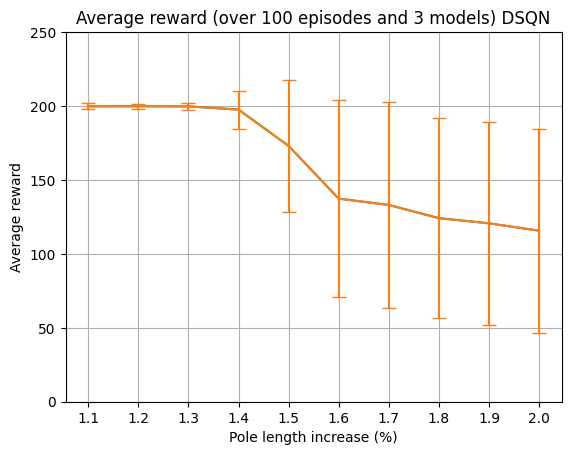

In [14]:
fig = plt.figure()
plt.plot(percentages, mean_avgs)
plt.errorbar(percentages, mean_avgs, std_dev_avgs, capsize=5)
plt.ylim(0, 250)
plt.grid(True)
plt.xlabel("Pole length increase (%)")
plt.xticks(percentages)
plt.ylabel("Average reward")
plt.title("Average reward (over 100 episodes and 3 models) DSQN")
plt.savefig("figs/pre-trained_DSQN_3models_evaluation.png", dpi=300)

### Evaluate pre-trained models on modified environment

In [28]:
modified_env_eval_rewards = []

for i, w in enumerate(weights):
    print('Run {:02d} ...'.format(i), end='')
    policy_net = RSTDPNet(alpha, beta, threshold, architecture, simulation_time, w,
                                  device=device, dtype=dtype)
    rewards = evaluate_policy(policy_net, modified_env, n_evaluations, evaluation_seeds)
    modified_env_eval_rewards.append(rewards)
    print(eraser*3 + '-> Avg reward: {:7.2f}'.format(np.mean(rewards)))

Run 00 -> Avg reward:  186.41
Run 01 -> Avg reward:  200.00
Run 02 -> Avg reward:  132.76


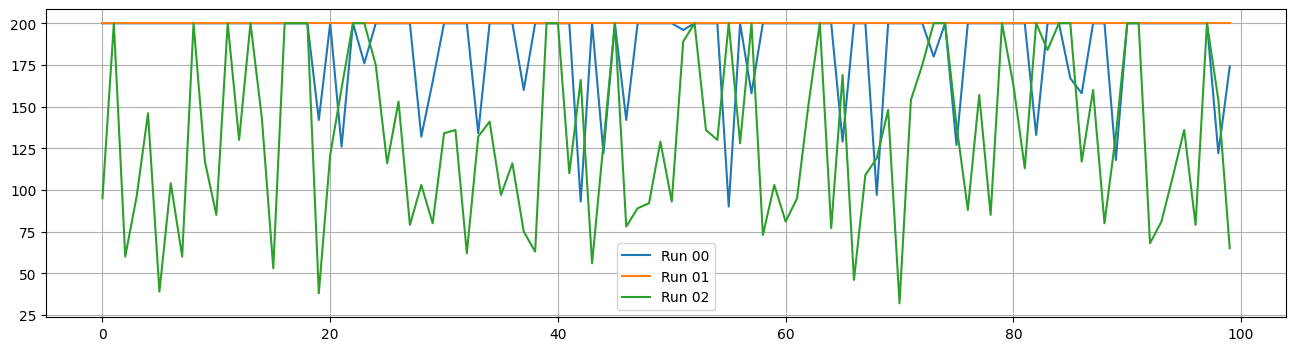

In [29]:
plt.figure(figsize=(16, 4))

for i, meer in enumerate(modified_env_eval_rewards):
    plt.plot(meer, label='Run {:02d}'.format(i))

plt.legend()
plt.grid()
plt.show()

### RSTDP Adaptation

In [14]:
rstdp_adaptation_rewards = []
adapted_weights_collection = []

for i, w in enumerate(weights):
    w_plus = deepcopy(w[0][1])
    w_minus = deepcopy(w[0][1])
    w_plus[w_plus < 0] = 0
    w_minus[w_minus > 0] = 0
    A_plus = torch.mean(w_plus)
    A_minus = torch.abs(torch.mean(w_minus))
    
    policy_net = RSTDPNet(alpha, beta, threshold, architecture, simulation_time, w, 
                                  tau, tau_e, A_plus, A_minus, C, 
                                  device=device, dtype=dtype)
    
    adapted_weights, rewards = rstdp_train_cartpole(policy_net, modified_env, max_reward, rstdp_episodes, 
                                                 n_evaluations, max_steps, rstdp_seeds, evaluation_seeds)
    
    rstdp_adaptation_rewards.append(rewards)
    adapted_weights_collection.append(adapted_weights)
    
adapted_weights_collection = [(list(aw.values()), []) for aw in adapted_weights_collection]

KeyboardInterrupt: 

### Evaluate adapted models on modified environment

In [15]:
adapted_eval_rewards = []

for i, w in enumerate(adapted_weights_collection):
    print('Run {:02d} ...'.format(i), end='')
    policy_net = RSTDPNet(alpha, beta, threshold, architecture, simulation_time, w,
                                  device=device, dtype=dtype)
    rewards = evaluate_policy(policy_net, modified_env, n_evaluations, evaluation_seeds)
    adapted_eval_rewards.append(rewards)
    print(eraser*3 + '-> Avg reward: {:7.2f}'.format(np.mean(rewards)))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


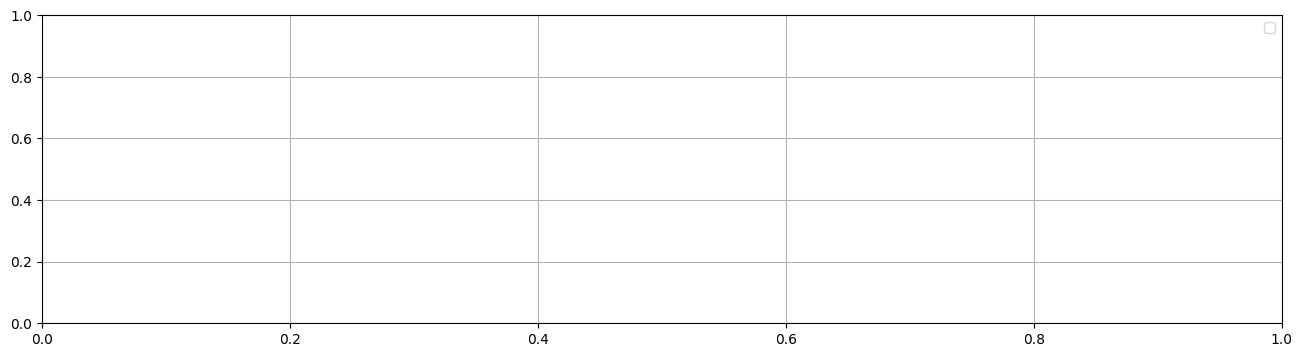

In [16]:
plt.figure(figsize=(16, 4))

for i, aer in enumerate(adapted_eval_rewards):
    plt.plot(aer, label='Run {:02d}'.format(i))

plt.legend()
plt.grid()
plt.show()